In [79]:
from functools import reduce
import json
import matplotlib
import os
import operator
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import sys

module_path = os.path.abspath(os.path.join('../src'))
if not module_path in sys.path:
    sys.path.insert(0, module_path)

from innoprod.sheet_tools import get_sheet_dfs
from innoprod.wrangling.wrangling_tools import characterise_df_columnwise, is_non_empty
from innoprod.wrangling.msyh_data_sharing import wrangle_roadmaps, wrangle_grants

In [4]:
data = get_sheet_dfs()
roadmaps_df = wrangle_roadmaps(data['Roadmaps'])
grants_df = wrangle_grants(data['Grants'])

# Basic Data Characterisation

In [5]:
roadmaps_characterisation = characterise_df_columnwise(roadmaps_df)
roadmaps_characterisation.to_csv('characterisation_roadmaps.csv')

In [6]:
grants_characterisation = characterise_df_columnwise(grants_df)
grants_characterisation.to_csv('characterisation_grants.csv')

In [7]:
df = data['Roadmaps']
col = 'Number of PT employees'
mask = (df[col] == '') == (df[col].isna())
df[mask][col].unique().size

np.int64(2)

## Cross-referencing Roadmaps and Grants
The two lists of **Client ID**s overlap perfectly:

In [8]:
set(grants_df['Client ID']) == set(roadmaps_df['Client ID'])

True

## Do withdrawn grant applications mean clients pull out completely?
This many clients withdrew from the scheme all together:

In [9]:
mask = grants_df['Application Status'] != 'Withdrew'

len(set(roadmaps_df['Client ID']).difference(set(grants_df[mask]['Client ID'])))

10

# Does Roadmaps > Number of GAFs match up with the data on Grants?

In [10]:
sum(roadmaps_df['Number of GAFs']) == grants_df['Grant ID'].count()

np.True_

# How many Roadmaps rows have all core data?

In [11]:
core_cols = [
    'Client ID',
    'Number of GAFs',
    'Primary_contact_id',
    'Nature of Business/core activity',
    'Turnover',
    'Enquiry Date',
    'Org Size by Number of FTE (calc)',
    'Number of FTE Employees (calc)',
    'Summary review of Edge Digital diagnostic report & current state and key improvement areas',
    'Current Digital Readiness Score (refer to PAS:1040)',
    'What are the internal barriers to growth? How do you intend to finance future growth? Are there sufficient leadership and management skills in the business to achieve your growth? What opportunities do you have to expand into new markets?',
    'Main historical barrier',
    'Details of any existing Digital Strategy',
    'Do you have a Digital Champion in place?',
    'Level of current Strategic Digital Skills/knowledge in the business',
    'Level of current Technical Digital Skills/knowledge in the business',
    'Whether the business is already investing/adopting/utilising Industry 4.0 Technologies, with examples',
    'Summary of the identified problems, including Gap Analysis',
    'Key potential industry 4.0 solutions to address the identified problems/gaps',
    'Recommended Action Plan to utilise Industry 4.0 Technology',
    'Overview of qualitative benefits of recommended Action Plan (positive/negative)',
    'Skills and other requirements that will be needed to successfully implement the recommended Action Plan',
    'Application area of technology in the Action Plan'
]

reqs_plans = [
   'Requirements/Plans: Short Term',
   'Requirements/Plans: Medium Term', 
   'Requirements/Plans: Long Term'
]

In [12]:
core_mask = [is_non_empty(roadmaps_df[col]) for col in core_cols]
core_mask = reduce(operator.and_, core_mask)

reqs_mask = [is_non_empty(roadmaps_df[col]) for col in reqs_plans]
reqs_mask = reduce(operator.or_, reqs_mask)

core_mask = core_mask & reqs_mask
sum(core_mask)

np.int64(90)

# Counting clients by size
* All clients
* Only those clients with values in all the core columns 

In [13]:
roadmaps_df.groupby('Org Size by Number of FTE (calc)').size()

Org Size by Number of FTE (calc)
                     7
Medium - 50-249     43
Micro - 1-9         60
Small - 10-49      110
dtype: int64

In [14]:
roadmaps_df[core_mask].groupby('Org Size by Number of FTE (calc)').size()

Org Size by Number of FTE (calc)
Medium - 50-249    17
Micro - 1-9        27
Small - 10-49      46
dtype: int64

## Analysis of zeros in FTE Employees

In [15]:
zero_fte_mask = (roadmaps_df['Number of FTE Employees (calc)'] == 0).fillna(False)
sum(zero_fte_mask)
# zero_fte_mask

np.int64(81)

In [16]:
nan_fte_mask = roadmaps_df['Number of FTE Employees (calc)'].isna()
sum(nan_fte_mask)

7

In [17]:
roadmaps_df[zero_fte_mask].groupby('Org Size by Number of FTE (calc)').size()

Org Size by Number of FTE (calc)
Medium - 50-249    15
Micro - 1-9        24
Small - 10-49      42
dtype: int64

In [18]:
roadmaps_df[zero_fte_mask][['Org Size by Number of FTE (calc)', 'Number of FT employees', 'Number of PT employees', 'Willing to be approached for case study?']]

,Org Size by Number of FTE (calc),Number of FT employees,Number of PT employees,Willing to be approached for case study?
0,Micro - 1-9,<NA>,<NA>,No
8,Small - 10-49,<NA>,<NA>,No
16,Small - 10-49,<NA>,<NA>,NaN
19,Medium - 50-249,<NA>,<NA>,NaN
21,Small - 10-49,<NA>,<NA>,
...,...,...,...,...
208,Small - 10-49,<NA>,<NA>,Yes
211,Small - 10-49,<NA>,<NA>,NaN
212,Micro - 1-9,<NA>,<NA>,Yes
216,Medium - 50-249,<NA>,<NA>,Yes


In [19]:
roadmaps_df[nan_fte_mask][['Org Size by Number of FTE (calc)', 'Number of FT employees', 'Number of PT employees', 'Willing to be approached for case study?']]

,Org Size by Number of FTE (calc),Number of FT employees,Number of PT employees,Willing to be approached for case study?
3,,<NA>,<NA>,NaN
75,,<NA>,<NA>,No
82,,<NA>,<NA>,Yes
156,,<NA>,<NA>,Yes
173,,<NA>,<NA>,
177,,<NA>,<NA>,No
179,,<NA>,<NA>,No


# Willing to be approached for case study

In [20]:
willing_mask = (roadmaps_df['Willing to be approached for case study?'] == 'Yes')

In [21]:
sum(willing_mask)

90

In [22]:
sum(willing_mask & core_mask)

np.int64(38)

In [23]:
roadmaps_df[willing_mask].groupby('Org Size by Number of FTE (calc)').size()

Org Size by Number of FTE (calc)
                    2
Medium - 50-249    23
Micro - 1-9        21
Small - 10-49      44
dtype: int64

In [24]:
roadmaps_df[willing_mask & core_mask].groupby('Org Size by Number of FTE (calc)').size()

Org Size by Number of FTE (calc)
Medium - 50-249     7
Micro - 1-9        10
Small - 10-49      21
dtype: int64

# Incorportating grants data

In [25]:
grants_df.groupby(['Application Status', 'Claim Status']).size()

Application Status  Claim Status
                    Defrayed         44
Defrayed            Defrayed        183
Engaged             Defrayed         51
Offered             Defrayed         12
Withdrew            Withdrawn        23
dtype: int64

In [26]:
defrayed_mask = (grants_df['Claim Status'] == 'Defrayed')
grants_totals = grants_df[defrayed_mask][['Client ID', 'Actual amount claimed']].groupby('Client ID').sum()
grants_totals = grants_totals.rename(columns={'Actual amount claimed': 'Total actual amount claimed'})

In [50]:
quant_df = roadmaps_df[[
    'Client ID', 
    'Number of GAFs',
    'Current Digital Readiness Score (refer to PAS:1040)',
]].join(grants_totals, on='Client ID')
quant_df = quant_df.rename(columns={
    'Number of GAFs': 'Num GAFs', 
    'Current Digital Readiness Score (refer to PAS:1040)': 'Current DRS', 
    'Total actual amount claimed': '£ claimed'
})
quant_df = quant_df.dropna()

array([[<Axes: xlabel='Num GAFs', ylabel='Num GAFs'>,
        <Axes: xlabel='Current DRS', ylabel='Num GAFs'>,
        <Axes: xlabel='£ claimed', ylabel='Num GAFs'>],
       [<Axes: xlabel='Num GAFs', ylabel='Current DRS'>,
        <Axes: xlabel='Current DRS', ylabel='Current DRS'>,
        <Axes: xlabel='£ claimed', ylabel='Current DRS'>],
       [<Axes: xlabel='Num GAFs', ylabel='£ claimed'>,
        <Axes: xlabel='Current DRS', ylabel='£ claimed'>,
        <Axes: xlabel='£ claimed', ylabel='£ claimed'>]], dtype=object)

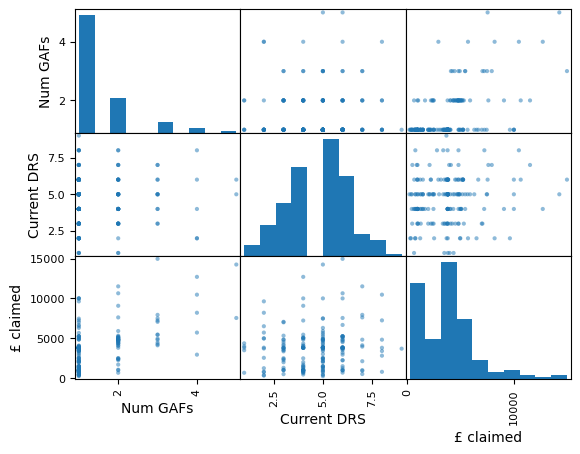

In [51]:
pd.plotting.scatter_matrix(quant_df)

In [73]:
x = quant_df['Current DRS'].values.reshape(-1, 1)
y = quant_df['£ claimed'].values.reshape(-1, 1)

drs_claim = LinearRegression()
drs_claim.fit(x, y)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [80]:
r2_score(x, y)

-8564161.059798356

Text(0, 0.5, '£ claimed')

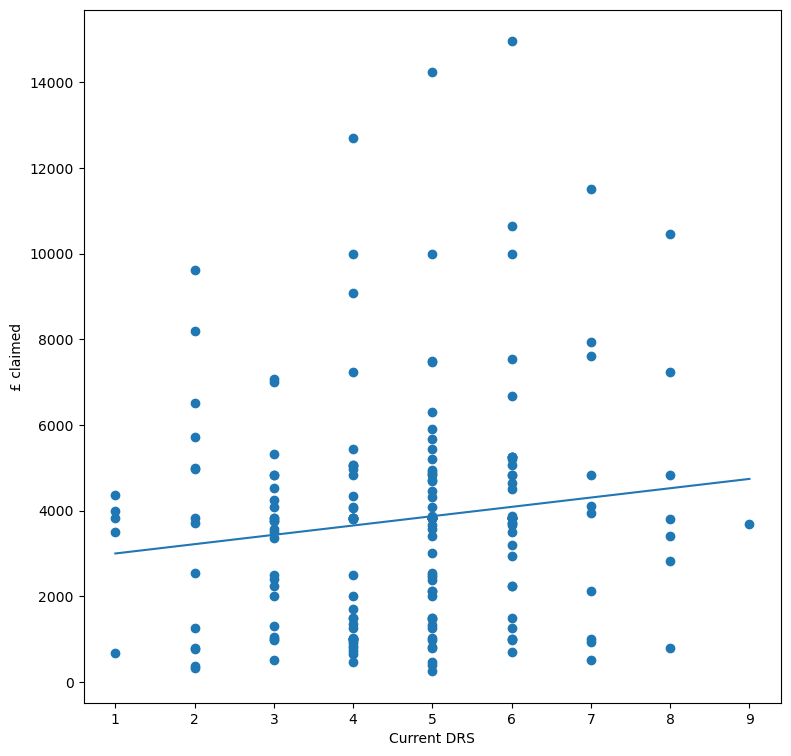

In [77]:
x_range = pd.array([x.min(), x.max()], dtype="Int64").reshape(-1, 1)

fig, ax = matplotlib.pyplot.subplots(figsize=(9,9))
ax.scatter(x, y)
ax.plot(x_range, drs_claim.predict(x_range))
ax.set_xlabel('Current DRS')
ax.set_ylabel('£ claimed')